### Data Download

In [ ]:
# RUN ONLY IF YOU DONT HAVE DATA SET YET

from zipfile import ZipFile
import os
import requests

urls = [
    "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip",
    "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip"
]

data_dir = "../loppuprojekti/data"
os.makedirs(data_dir, exist_ok=True)

for url in urls:
    filename = os.path.join(data_dir, os.path.basename(url))
    # Download zip file
    print(f"Downloading {url}...")
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    print("Download ready:", filename)
    # Exctract zip file
    print(f"Extracting {filename}...")
    with ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    print("Extracted files!")

print("Data pulling ready:", data_dir)

### Data Preparation

In [2]:
import random
import shutil
import os
import keras
import tensorflow as tf
from keras import ops

# For GPU logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

data_dir = "../loppuprojekti/data"
train = "../loppuprojekti/data/DIV2K_train_HR/"
validation = "../loppuprojekti/data/DIV2K_valid_HR/"
test = "../loppuprojekti/data/DIV2K_test_HR"

os.makedirs(test, exist_ok=True)

train_files = os.listdir(train)

num_test_files = int(len(train_files) * 0.15)

files_to_move = random.sample(train_files, num_test_files)

if not os.listdir(test):
    for file in files_to_move:
        src = os.path.join(train, file)
        dst = os.path.join(test, file)
        shutil.move(src, dst)

    print(f"Moved {len(files_to_move)} files to test directory")

else:
    print("Test files already exist")

Test files already exist


In [3]:
# NOT IN USAGE | tensorflow has this dataset already
'''import os; os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

import keras
from keras import layers
from keras import ops

AUTOTUNE = tf.data.AUTOTUNE

div2k_data = tfds.image.Div2k(config="bicubic_x4")
div2k_data.download_and_prepare()

# Taking train data from div2k_data object
train = div2k_data.as_dataset(split="train", as_supervised=True)
train_cache = train.cache()
# Validation data
val = div2k_data.as_dataset(split="validation", as_supervised=True)
val_cache = val.cache()'''

'import os; os.environ["KERAS_BACKEND"] = "tensorflow"\n\nimport numpy as np\nimport tensorflow as tf\nimport tensorflow_datasets as tfds\nimport matplotlib.pyplot as plt\n\nimport keras\nfrom keras import layers\nfrom keras import ops\n\nAUTOTUNE = tf.data.AUTOTUNE\n\ndiv2k_data = tfds.image.Div2k(config="bicubic_x4")\ndiv2k_data.download_and_prepare()\n\n# Taking train data from div2k_data object\ntrain = div2k_data.as_dataset(split="train", as_supervised=True)\ntrain_cache = train.cache()\n# Validation data\nval = div2k_data.as_dataset(split="validation", as_supervised=True)\nval_cache = val.cache()'

#### Data Augmentation Helper Functions

In [4]:
def flip_left_right(lowres_img, highres_img):
    """Flips Images to left and right."""

    # Outputs random values from a uniform distribution in between 0 to 1
    rn = keras.random.uniform(shape=(), maxval=1)
    # If rn is less than 0.5 it returns original lowres_img and highres_img
    # If rn is greater than 0.5 it returns flipped image
    return ops.cond(
        rn < 0.5,
        lambda: (lowres_img, highres_img),
        lambda: (
            ops.flip(lowres_img),
            ops.flip(highres_img),
        ),
    )


def random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""

    # Outputs random values from uniform distribution in between 0 to 4
    rn = ops.cast(
        keras.random.uniform(shape=(), maxval=4, dtype="float32"), dtype="int32"
    )
    # Here rn signifies number of times the image(s) are rotated by 90 degrees
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)


def random_crop(lowres_img, highres_img, hr_crop_size=96, scale=4):
    """Crop images.

    low resolution images: 24x24
    high resolution images: 96x96
    """
    lowres_crop_size = hr_crop_size // scale  # 96//4=24
    lowres_img_shape = ops.shape(lowres_img)[:2]  # (height,width)

    lowres_width = ops.cast(
        keras.random.uniform(
            shape=(), maxval=lowres_img_shape[1] - lowres_crop_size + 1, dtype="float32"
        ),
        dtype="int32",
    )
    lowres_height = ops.cast(
        keras.random.uniform(
            shape=(), maxval=lowres_img_shape[0] - lowres_crop_size + 1, dtype="float32"
        ),
        dtype="int32",
    )

    highres_width = lowres_width * scale
    highres_height = lowres_height * scale

    lowres_img_cropped = lowres_img[
        lowres_height : lowres_height + lowres_crop_size,
        lowres_width : lowres_width + lowres_crop_size,
    ]  # 24x24
    highres_img_cropped = highres_img[
        highres_height : highres_height + hr_crop_size,
        highres_width : highres_width + hr_crop_size,
    ]  # 96x96

    return lowres_img_cropped, highres_img_cropped

def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value

#### Image Augmentation Main Function

In [5]:
def dataset_object(ds, training=True):
    ds = ds.map(
        lambda lowres, highres: random_crop(lowres, highres, scale=4),
        num_parallel_calls=AUTOTUNE,
    )

    if training:
        ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.map(flip_left_right, num_parallel_calls=AUTOTUNE)
    # Batching Data
    ds = ds.batch(16)

    if training:
        # Repeating Data, so that cardinality if dataset becomes infinte
        ds = ds.repeat()
    # prefetching allows later images to be prepared while the current image is being processed
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds



#### Dataset Creation

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
crop_size = 96
scale = 4



import os

train_dir = os.path.join(data_dir, "DIV2K_train_HR")
val_dir = os.path.join(data_dir, "DIV2K_valid_HR")
test_dir = os.path.join(data_dir, "DIV2K_test_HR")

train_files = [
    os.path.join(train_dir, fname)
    for fname in os.listdir(train_dir)
    if fname.lower().endswith((".png", ".jpg", ".jpeg"))
]

val_files = [
    os.path.join(val_dir, fname)
    for fname in os.listdir(val_dir)
    if fname.lower().endswith((".png", ".jpg", ".jpeg"))
]

test_files = [
    os.path.join(test_dir, fname)
    for fname in os.listdir(test_dir)
    if fname.lower().endswith((".png", ".jpg", ".jpeg"))
]



def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])

    return img



def random_crop_and_downscale(hr_img):
    hr_patch = tf.image.random_crop(hr_img, size=[crop_size, crop_size, 3])
    hr_patch.set_shape([crop_size, crop_size, 3])
    lr_patch = tf.image.resize(
        hr_patch, [crop_size // scale, crop_size // scale], method="area"
    )
    lr_patch.set_shape([crop_size // scale, crop_size // scale, 3])
    return lr_patch, hr_patch



# Build datasets


train_ds = tf.data.Dataset.from_tensor_slices(train_files).map(
    load_image, num_parallel_calls=tf.data.AUTOTUNE
)


val_ds = tf.data.Dataset.from_tensor_slices(val_files).map(
    load_image, num_parallel_calls=tf.data.AUTOTUNE
)


test_ds = tf.data.Dataset.from_tensor_slices(test_files).map(
    load_image, num_parallel_calls=tf.data.AUTOTUNE
)


# Apply random cropping and downscaling
BATCH_SIZE = 8

train_sr = train_ds.map(random_crop_and_downscale, num_parallel_calls=tf.data.AUTOTUNE)
train_sr = train_sr.map(random_rotate, num_parallel_calls=tf.data.AUTOTUNE)
train_sr = train_sr.map(flip_left_right, num_parallel_calls=tf.data.AUTOTUNE)
train_sr = train_sr.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

def downscale_full_image(hr_img):
    hr_shape = tf.shape(hr_img)
    h, w = hr_shape[0], hr_shape[1]
    lr_img = tf.image.resize(hr_img, [h // scale, w // scale], method="area")
    return lr_img, hr_img


VAL_IMAGE_SIZE = 384  # OOM over 384x384 image size
VAL_BATCH_SIZE = 1    # Val batch size

def resize_pair(lr_img, hr_img, size=(VAL_IMAGE_SIZE, VAL_IMAGE_SIZE)):
    lr_img = tf.image.resize(lr_img, size, method="area")
    hr_img = tf.image.resize(hr_img, (size[0]*scale, size[1]*scale), method="area")
    return lr_img, hr_img

val_sr = val_ds.map(downscale_full_image, num_parallel_calls=tf.data.AUTOTUNE)
val_sr = val_sr.map(lambda lr, hr: resize_pair(lr, hr, size=(VAL_IMAGE_SIZE, VAL_IMAGE_SIZE)), num_parallel_calls=tf.data.AUTOTUNE)
val_sr = val_sr.batch(VAL_BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

'''val_sr = val_ds
#val_sr = val_ds.map(random_crop_and_downscale, num_parallel_calls=tf.data.AUTOTUNE)
val_sr = val_sr.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)'''

test_sr = test_ds
#test_sr = test_ds.map(random_crop_and_downscale, num_parallel_calls=tf.data.AUTOTUNE)
test_sr = test_sr.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# Example: print shapes

for lr, hr in train_sr.take(1):
    print("LR patch shape:", lr.shape)
    print("HR patch shape:", hr.shape)

I0000 00:00:1746282386.577846   29885 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6687 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:0a:00.0, compute capability: 6.1


LR patch shape: (8, 24, 24, 3)
HR patch shape: (8, 96, 96, 3)


2025-05-03 17:26:27.904139: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Plot Example of Training Data

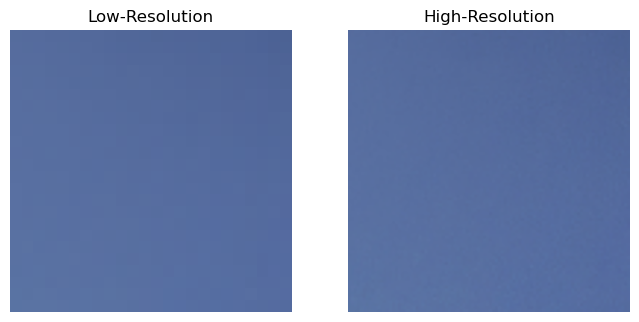

2025-05-03 17:26:28.689584: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
import matplotlib.pyplot as plt

# Get one LR-HR pair from the dataset
for lr, hr in train_sr.take(1):
    lr_img = lr.numpy()
    hr_img = hr.numpy()

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Low-Resolution")
    plt.imshow(lr_img[0])
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("High-Resolution")
    plt.imshow(hr_img[0])
    plt.axis("off")

    plt.show()

#### Utility Functions

In [8]:
from keras import layers
from keras.saving import register_keras_serializable
from keras.applications.vgg19 import preprocess_input
from keras import Model


# Utilities
@register_keras_serializable()
class PixelShuffle(layers.Layer):
    def __init__(self, scale, **kwargs):
        super().__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, block_size=self.scale)

    def get_config(self):
        config = super().get_config()
        config.update({"scale": self.scale})
        return config


@register_keras_serializable()
def PSNR(original, generated):
    return tf.image.psnr(original, generated, max_val=1.0)


def save_model(model, filepath):
    model.save(filepath)


@register_keras_serializable()
def load_model(filepath):
    return keras.models.load_model(filepath)

@register_keras_serializable()
def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def combined_loss(y_true, y_pred):
    # Preprocess for VGG
    y_true_vgg = preprocess_vgg(y_true)
    y_pred_vgg = preprocess_vgg(y_pred)

    # Extract features
    f_true = vgg_model(y_true_vgg)
    f_pred = vgg_model(y_pred_vgg)

    # Perceptual loss: feature-wise MSE
    perceptual = tf.reduce_mean(tf.square(f_true - f_pred))
    pixel = tf.reduce_mean(tf.abs(y_true - y_pred))
    return 0.1 * perceptual + 1.0 * pixel

# Perceptual loss with VGG
vgg = keras.applications.VGG19(include_top=False, weights="imagenet")
vgg.trainable = False
vgg_model = Model(inputs=vgg.input, outputs=vgg.get_layer("block3_conv3").output)


def preprocess_vgg(x):
    x = tf.image.resize(x, [224, 224])
    x = preprocess_input(x * 255.0)
    return x


def combined_loss(y_true, y_pred):
    # Preprocess for VGG
    y_true_vgg = preprocess_vgg(y_true)
    y_pred_vgg = preprocess_vgg(y_pred)

    # Extract features
    f_true = vgg_model(y_true_vgg)
    f_pred = vgg_model(y_pred_vgg)

    # Perceptual loss: feature-wise MSE
    perceptual = tf.reduce_mean(tf.square(f_true - f_pred))
    pixel = tf.reduce_mean(tf.abs(y_true - y_pred))
    return 0.05 * perceptual + 1.0 * pixel


#### Construction of Model

In [9]:
from keras import layers, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam




reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

early_stop = EarlyStopping(
    monitor="val_psnr",  # or val_calculate_psnr for PSNR
    patience=20,
    restore_best_weights=True,
    mode='max'
)

optimizer = Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)


# Residual block layers
def ResBlock(inputs, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x


# Up sampling layer
def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor**2), 3, padding="same", **kwargs)(inputs)
    x = PixelShuffle(factor)(x)
    x = layers.Conv2D(64 * (factor**2), 3, padding="same", **kwargs)(x)
    x = PixelShuffle(factor)(x)
    return x


# Model creation function
def make_model(num_filters, num_of_residual_blocks):
    input_layer = layers.Input(shape=(None, None, 3))
    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new, num_filters)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x, factor=2)
    x = layers.Conv2D(3, 3, padding="same")(x)

    output_layer = layers.Activation("sigmoid")(x)
    return Model(inputs=input_layer, outputs=output_layer)


model = make_model(num_filters=100, num_of_residual_blocks=20)

In [10]:

model.compile(optimizer=optimizer, loss="mae", metrics=[PSNR, SSIM])
model.fit(train_sr, validation_data=val_sr, epochs=150, callbacks=[early_stop])
model.save_weights("mae.weights.h5")

Epoch 1/150


I0000 00:00:1746282399.349459   29951 service.cc:152] XLA service 0x7f1ca40043e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746282399.349583   29951 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2025-05-03 17:26:39.976450: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-03 17:26:40.710623: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert/Assert
2025-05-03 17:26:40.710735: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert_1/Assert
2025-05-03 17:26:40.712531: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert/Assert
2025-05-03 17:26:40.712730: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_1/Assert
2025-05

 3/85 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.2116 - psnr: 13.3272 - ssim: 0.4760  

I0000 00:00:1746282413.594730   29951 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1877 - psnr: 13.8404 - ssim: 0.3193

2025-05-03 17:27:06.608283: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert/Assert
2025-05-03 17:27:06.608440: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert_1/Assert
2025-05-03 17:27:06.610205: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert/Assert
2025-05-03 17:27:06.610337: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_1/Assert
2025-05-03 17:27:06.610685: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_2/Assert
2025-05-03 17:27:06.610854: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_3/Assert
2025-05-03 17:27:07.207499: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.178 = (f32[1,100,384,384]{3,2,1,0}, u8[0]{0}) cus

85/85 ━━━━━━━━━━━━━━━━━━━━ 65s 495ms/step - loss: 0.1869 - psnr: 13.8737 - ssim: 0.3203 - val_loss: 0.1045 - val_psnr: 17.8051 - val_ssim: 0.5512
Epoch 2/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 405ms/step - loss: 0.1119 - psnr: 17.7892 - ssim: 0.4567 - val_loss: 0.0972 - val_psnr: 18.4026 - val_ssim: 0.5551
Epoch 3/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 34s 403ms/step - loss: 0.0970 - psnr: 19.1623 - ssim: 0.5000 - val_loss: 0.1252 - val_psnr: 16.3398 - val_ssim: 0.4825
Epoch 4/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 34s 403ms/step - loss: 0.1008 - psnr: 18.8137 - ssim: 0.5044 - val_loss: 0.0839 - val_psnr: 19.4454 - val_ssim: 0.5882
Epoch 5/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 405ms/step - loss: 0.0927 - psnr: 19.7241 - ssim: 0.5465 - val_loss: 0.0963 - val_psnr: 18.3158 - val_ssim: 0.5931
Epoch 6/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 34s 403ms/step - loss: 0.0979 - psnr: 19.2380 - ssim: 0.5321 - val_loss: 0.0832 - val_psnr: 19.5276 - val_ssim: 0.6103
Epoch 7/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 34s 403ms/step - loss: 0.

2025-05-03 17:37:01.005105: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 37027840 bytes after encountering the first element of size 37027840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 408ms/step - loss: 0.0823 - psnr: 20.9916 - ssim: 0.6159 - val_loss: 0.0787 - val_psnr: 19.8683 - val_ssim: 0.6584
Epoch 19/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 404ms/step - loss: 0.0820 - psnr: 21.0411 - ssim: 0.6348 - val_loss: 0.0819 - val_psnr: 19.7697 - val_ssim: 0.6394
Epoch 20/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 34s 402ms/step - loss: 0.0818 - psnr: 20.9665 - ssim: 0.6334 - val_loss: 0.0762 - val_psnr: 20.1897 - val_ssim: 0.6719
Epoch 21/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 405ms/step - loss: 0.0790 - psnr: 21.2771 - ssim: 0.6359 - val_loss: 0.0777 - val_psnr: 19.8844 - val_ssim: 0.6588
Epoch 22/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 34s 401ms/step - loss: 0.0818 - psnr: 20.9290 - ssim: 0.6306 - val_loss: 0.0803 - val_psnr: 19.9329 - val_ssim: 0.6552
Epoch 23/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 408ms/step - loss: 0.0801 - psnr: 21.2212 - ssim: 0.6428 - val_loss: 0.0751 - val_psnr: 20.3059 - val_ssim: 0.6665
Epoch 24/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 405ms/step - lo

2025-05-03 17:41:08.823106: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35594240 bytes after encountering the first element of size 35594240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 40s 471ms/step - loss: 0.0804 - psnr: 20.9197 - ssim: 0.6270 - val_loss: 0.0791 - val_psnr: 19.9150 - val_ssim: 0.6423
Epoch 26/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0677 - psnr: 22.1326 - ssim: 0.6324

2025-05-03 17:41:43.991084: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 37027840 bytes after encountering the first element of size 37027840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 413ms/step - loss: 0.0678 - psnr: 22.1246 - ssim: 0.6324 - val_loss: 0.0660 - val_psnr: 21.5183 - val_ssim: 0.6632
Epoch 27/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 412ms/step - loss: 0.0657 - psnr: 22.2269 - ssim: 0.6358 - val_loss: 0.0547 - val_psnr: 23.0228 - val_ssim: 0.6759
Epoch 28/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 412ms/step - loss: 0.0612 - psnr: 22.8751 - ssim: 0.6439 - val_loss: 0.0570 - val_psnr: 22.5911 - val_ssim: 0.6754
Epoch 29/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 419ms/step - loss: 0.0603 - psnr: 23.0496 - ssim: 0.6422 - val_loss: 0.0591 - val_psnr: 22.5325 - val_ssim: 0.6740
Epoch 30/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 415ms/step - loss: 0.0638 - psnr: 22.6977 - ssim: 0.6530 - val_loss: 0.0498 - val_psnr: 23.4791 - val_ssim: 0.6903
Epoch 31/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0557 - psnr: 23.8757 - ssim: 0.6489

2025-05-03 17:44:40.730969: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 37027840 bytes after encountering the first element of size 37027840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 416ms/step - loss: 0.0557 - psnr: 23.8721 - ssim: 0.6489 - val_loss: 0.0570 - val_psnr: 22.7421 - val_ssim: 0.6822
Epoch 32/150
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0552 - psnr: 23.8679 - ssim: 0.6543

2025-05-03 17:45:16.295294: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35594240 bytes after encountering the first element of size 35594240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 416ms/step - loss: 0.0552 - psnr: 23.8676 - ssim: 0.6542 - val_loss: 0.0541 - val_psnr: 22.8925 - val_ssim: 0.6918
Epoch 33/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0568 - psnr: 23.7762 - ssim: 0.6562

2025-05-03 17:45:52.081139: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 427ms/step - loss: 0.0568 - psnr: 23.7769 - ssim: 0.6562 - val_loss: 0.0539 - val_psnr: 23.3139 - val_ssim: 0.6813
Epoch 34/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 419ms/step - loss: 0.0516 - psnr: 24.6933 - ssim: 0.6802 - val_loss: 0.0509 - val_psnr: 23.4975 - val_ssim: 0.6969
Epoch 35/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0526 - psnr: 24.2742 - ssim: 0.6624

2025-05-03 17:47:05.753783: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 450ms/step - loss: 0.0526 - psnr: 24.2719 - ssim: 0.6623 - val_loss: 0.0522 - val_psnr: 23.1129 - val_ssim: 0.6958
Epoch 36/150
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0571 - psnr: 23.8021 - ssim: 0.6687

2025-05-03 17:47:44.282601: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 37027840 bytes after encountering the first element of size 37027840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 443ms/step - loss: 0.0571 - psnr: 23.8039 - ssim: 0.6686 - val_loss: 0.0464 - val_psnr: 24.0716 - val_ssim: 0.7019
Epoch 37/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0525 - psnr: 24.4796 - ssim: 0.6631

2025-05-03 17:48:22.236774: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 36864000 bytes after encountering the first element of size 36864000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 444ms/step - loss: 0.0525 - psnr: 24.4792 - ssim: 0.6632 - val_loss: 0.0480 - val_psnr: 23.8930 - val_ssim: 0.6983
Epoch 38/150
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0513 - psnr: 24.8051 - ssim: 0.6710

2025-05-03 17:49:00.038365: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 430ms/step - loss: 0.0513 - psnr: 24.7967 - ssim: 0.6711 - val_loss: 0.0520 - val_psnr: 23.3721 - val_ssim: 0.6940
Epoch 39/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 433ms/step - loss: 0.0509 - psnr: 24.5734 - ssim: 0.6846 - val_loss: 0.0537 - val_psnr: 23.2359 - val_ssim: 0.6902
Epoch 40/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0551 - psnr: 23.9845 - ssim: 0.6655

2025-05-03 17:50:13.507705: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 36864000 bytes after encountering the first element of size 36864000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 440ms/step - loss: 0.0551 - psnr: 23.9869 - ssim: 0.6654 - val_loss: 0.0495 - val_psnr: 23.6705 - val_ssim: 0.7091
Epoch 41/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.0519 - psnr: 24.5951 - ssim: 0.6751

2025-05-03 17:50:51.815684: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 448ms/step - loss: 0.0518 - psnr: 24.5955 - ssim: 0.6751 - val_loss: 0.0479 - val_psnr: 23.8407 - val_ssim: 0.7028
Epoch 42/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0480 - psnr: 25.2612 - ssim: 0.6907

2025-05-03 17:51:30.505803: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35594240 bytes after encountering the first element of size 35594240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 446ms/step - loss: 0.0481 - psnr: 25.2559 - ssim: 0.6906 - val_loss: 0.0511 - val_psnr: 23.5865 - val_ssim: 0.6986
Epoch 43/150
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0519 - psnr: 24.5311 - ssim: 0.6792

2025-05-03 17:52:08.146292: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 442ms/step - loss: 0.0520 - psnr: 24.5253 - ssim: 0.6791 - val_loss: 0.0553 - val_psnr: 22.9550 - val_ssim: 0.7039
Epoch 44/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0533 - psnr: 24.3293 - ssim: 0.6640

2025-05-03 17:52:45.472575: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35594240 bytes after encountering the first element of size 35594240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 443ms/step - loss: 0.0533 - psnr: 24.3317 - ssim: 0.6641 - val_loss: 0.0483 - val_psnr: 23.8349 - val_ssim: 0.7084
Epoch 45/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0495 - psnr: 24.9537 - ssim: 0.6882

2025-05-03 17:53:23.292522: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35594240 bytes after encountering the first element of size 35594240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 444ms/step - loss: 0.0495 - psnr: 24.9526 - ssim: 0.6881 - val_loss: 0.0468 - val_psnr: 24.0916 - val_ssim: 0.7121
Epoch 46/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.0464 - psnr: 25.6141 - ssim: 0.7034

2025-05-03 17:54:01.489405: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 446ms/step - loss: 0.0464 - psnr: 25.6086 - ssim: 0.7033 - val_loss: 0.0477 - val_psnr: 23.8589 - val_ssim: 0.7150
Epoch 47/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 446ms/step - loss: 0.0532 - psnr: 24.2701 - ssim: 0.6609 - val_loss: 0.0485 - val_psnr: 23.8218 - val_ssim: 0.6905
Epoch 48/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0526 - psnr: 24.4524 - ssim: 0.6680

2025-05-03 17:55:17.322992: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 36864000 bytes after encountering the first element of size 36864000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 444ms/step - loss: 0.0526 - psnr: 24.4495 - ssim: 0.6680 - val_loss: 0.0518 - val_psnr: 23.4146 - val_ssim: 0.7118
Epoch 49/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0487 - psnr: 25.0709 - ssim: 0.6845

2025-05-03 17:55:56.583996: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 37027840 bytes after encountering the first element of size 37027840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 452ms/step - loss: 0.0487 - psnr: 25.0681 - ssim: 0.6845 - val_loss: 0.0589 - val_psnr: 22.4302 - val_ssim: 0.6959
Epoch 50/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0539 - psnr: 24.1835 - ssim: 0.6663

2025-05-03 17:56:34.729588: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35594240 bytes after encountering the first element of size 35594240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 454ms/step - loss: 0.0539 - psnr: 24.1862 - ssim: 0.6664 - val_loss: 0.0543 - val_psnr: 23.1945 - val_ssim: 0.7039
Epoch 51/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 452ms/step - loss: 0.0490 - psnr: 25.0887 - ssim: 0.6846 - val_loss: 0.0540 - val_psnr: 23.0946 - val_ssim: 0.7043
Epoch 52/150
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0512 - psnr: 24.6018 - ssim: 0.6909

2025-05-03 17:57:51.846598: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35594240 bytes after encountering the first element of size 35594240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 454ms/step - loss: 0.0512 - psnr: 24.6017 - ssim: 0.6909 - val_loss: 0.0472 - val_psnr: 23.9606 - val_ssim: 0.7113
Epoch 53/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0495 - psnr: 24.9122 - ssim: 0.6739

2025-05-03 17:58:30.537437: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 453ms/step - loss: 0.0495 - psnr: 24.9120 - ssim: 0.6740 - val_loss: 0.0474 - val_psnr: 24.0348 - val_ssim: 0.7117
Epoch 54/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0473 - psnr: 25.3714 - ssim: 0.6932

2025-05-03 17:59:09.293878: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 36864000 bytes after encountering the first element of size 36864000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 445ms/step - loss: 0.0474 - psnr: 25.3655 - ssim: 0.6932 - val_loss: 0.0435 - val_psnr: 24.4368 - val_ssim: 0.7255
Epoch 55/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 425ms/step - loss: 0.0478 - psnr: 25.3608 - ssim: 0.6892 - val_loss: 0.0439 - val_psnr: 24.3845 - val_ssim: 0.7223
Epoch 56/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 432ms/step - loss: 0.0496 - psnr: 24.9869 - ssim: 0.6893 - val_loss: 0.0463 - val_psnr: 24.0774 - val_ssim: 0.7135
Epoch 57/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 427ms/step - loss: 0.0483 - psnr: 25.2751 - ssim: 0.6917 - val_loss: 0.0483 - val_psnr: 23.9708 - val_ssim: 0.7046
Epoch 58/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.0494 - psnr: 25.1268 - ssim: 0.6980

2025-05-03 18:01:35.512944: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 37027840 bytes after encountering the first element of size 37027840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 426ms/step - loss: 0.0494 - psnr: 25.1209 - ssim: 0.6979 - val_loss: 0.0477 - val_psnr: 23.8268 - val_ssim: 0.7128
Epoch 59/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0513 - psnr: 24.6449 - ssim: 0.6863

2025-05-03 18:02:12.550422: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35594240 bytes after encountering the first element of size 35594240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 432ms/step - loss: 0.0513 - psnr: 24.6486 - ssim: 0.6864 - val_loss: 0.0448 - val_psnr: 24.3487 - val_ssim: 0.7130
Epoch 60/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.0480 - psnr: 25.4441 - ssim: 0.6960

2025-05-03 18:02:48.858707: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 37027840 bytes after encountering the first element of size 37027840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 425ms/step - loss: 0.0480 - psnr: 25.4466 - ssim: 0.6960 - val_loss: 0.0434 - val_psnr: 24.4810 - val_ssim: 0.7224
Epoch 61/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0442 - psnr: 26.4100 - ssim: 0.7024

2025-05-03 18:03:25.550057: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 431ms/step - loss: 0.0442 - psnr: 26.4057 - ssim: 0.7024 - val_loss: 0.0487 - val_psnr: 23.9818 - val_ssim: 0.7138
Epoch 62/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0442 - psnr: 26.0273 - ssim: 0.7128

2025-05-03 18:04:02.005884: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35594240 bytes after encountering the first element of size 35594240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 424ms/step - loss: 0.0442 - psnr: 26.0274 - ssim: 0.7128 - val_loss: 0.0441 - val_psnr: 24.4272 - val_ssim: 0.7188
Epoch 63/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0465 - psnr: 25.7294 - ssim: 0.7043

2025-05-03 18:04:38.208767: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 36864000 bytes after encountering the first element of size 36864000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 423ms/step - loss: 0.0465 - psnr: 25.7299 - ssim: 0.7044 - val_loss: 0.0446 - val_psnr: 24.3617 - val_ssim: 0.7222
Epoch 64/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 430ms/step - loss: 0.0467 - psnr: 25.7267 - ssim: 0.7077 - val_loss: 0.0458 - val_psnr: 24.2249 - val_ssim: 0.7175
Epoch 65/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0469 - psnr: 25.5404 - ssim: 0.6903

2025-05-03 18:05:52.876376: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 37027840 bytes after encountering the first element of size 37027840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 446ms/step - loss: 0.0469 - psnr: 25.5414 - ssim: 0.6903 - val_loss: 0.0449 - val_psnr: 24.2739 - val_ssim: 0.7149
Epoch 66/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0444 - psnr: 26.0441 - ssim: 0.7093

2025-05-03 18:06:30.219599: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 439ms/step - loss: 0.0444 - psnr: 26.0415 - ssim: 0.7093 - val_loss: 0.0453 - val_psnr: 24.2315 - val_ssim: 0.7204
Epoch 67/150
 3/85 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0488 - psnr: 24.8465 - ssim: 0.6557 

2025-05-03 18:06:53.304596: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 940032 bytes after encountering the first element of size 940032 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 441ms/step - loss: 0.0469 - psnr: 25.5809 - ssim: 0.7007 - val_loss: 0.0431 - val_psnr: 24.5216 - val_ssim: 0.7212
Epoch 68/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 437ms/step - loss: 0.0462 - psnr: 25.8123 - ssim: 0.7128 - val_loss: 0.0474 - val_psnr: 24.0044 - val_ssim: 0.7157
Epoch 69/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 432ms/step - loss: 0.0443 - psnr: 26.1777 - ssim: 0.7131 - val_loss: 0.0445 - val_psnr: 24.3893 - val_ssim: 0.7192
Epoch 70/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0449 - psnr: 25.9911 - ssim: 0.7082

2025-05-03 18:09:00.012802: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 37027840 bytes after encountering the first element of size 37027840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 442ms/step - loss: 0.0449 - psnr: 25.9913 - ssim: 0.7082 - val_loss: 0.0429 - val_psnr: 24.5871 - val_ssim: 0.7239
Epoch 71/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0452 - psnr: 25.9755 - ssim: 0.7002

2025-05-03 18:09:37.608283: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 439ms/step - loss: 0.0452 - psnr: 25.9749 - ssim: 0.7003 - val_loss: 0.0433 - val_psnr: 24.5379 - val_ssim: 0.7338
Epoch 72/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 433ms/step - loss: 0.0451 - psnr: 25.8227 - ssim: 0.7153 - val_loss: 0.0440 - val_psnr: 24.4465 - val_ssim: 0.7278
Epoch 73/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 437ms/step - loss: 0.0450 - psnr: 26.2842 - ssim: 0.7096 - val_loss: 0.0453 - val_psnr: 24.2929 - val_ssim: 0.7237
Epoch 74/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 439ms/step - loss: 0.0440 - psnr: 26.0710 - ssim: 0.7157 - val_loss: 0.0456 - val_psnr: 24.2201 - val_ssim: 0.7166
Epoch 75/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0438 - psnr: 26.1575 - ssim: 0.7161

2025-05-03 18:12:07.043632: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 442ms/step - loss: 0.0438 - psnr: 26.1561 - ssim: 0.7160 - val_loss: 0.0429 - val_psnr: 24.5392 - val_ssim: 0.7334
Epoch 76/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 438ms/step - loss: 0.0458 - psnr: 26.0909 - ssim: 0.7101 - val_loss: 0.0436 - val_psnr: 24.4631 - val_ssim: 0.7318
Epoch 77/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 440ms/step - loss: 0.0455 - psnr: 25.8464 - ssim: 0.7102 - val_loss: 0.0467 - val_psnr: 24.0763 - val_ssim: 0.7165
Epoch 78/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 440ms/step - loss: 0.0448 - psnr: 25.9738 - ssim: 0.7220 - val_loss: 0.0475 - val_psnr: 23.8003 - val_ssim: 0.7235
Epoch 79/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0458 - psnr: 25.8125 - ssim: 0.7118

2025-05-03 18:14:37.301244: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 36864000 bytes after encountering the first element of size 36864000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 444ms/step - loss: 0.0458 - psnr: 25.8135 - ssim: 0.7118 - val_loss: 0.0439 - val_psnr: 24.4039 - val_ssim: 0.7229
Epoch 80/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0450 - psnr: 26.2705 - ssim: 0.7125

2025-05-03 18:15:15.869006: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 452ms/step - loss: 0.0450 - psnr: 26.2682 - ssim: 0.7125 - val_loss: 0.0453 - val_psnr: 24.2244 - val_ssim: 0.7302
Epoch 81/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 450ms/step - loss: 0.0464 - psnr: 25.6803 - ssim: 0.7114 - val_loss: 0.0462 - val_psnr: 24.2146 - val_ssim: 0.7293
Epoch 82/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0461 - psnr: 25.5962 - ssim: 0.6980

2025-05-03 18:16:33.102562: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35594240 bytes after encountering the first element of size 35594240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 451ms/step - loss: 0.0461 - psnr: 25.5961 - ssim: 0.6981 - val_loss: 0.0422 - val_psnr: 24.6643 - val_ssim: 0.7371
Epoch 83/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 456ms/step - loss: 0.0464 - psnr: 25.7218 - ssim: 0.6997 - val_loss: 0.0447 - val_psnr: 24.4003 - val_ssim: 0.7289
Epoch 84/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 40s 474ms/step - loss: 0.0446 - psnr: 26.1756 - ssim: 0.7207 - val_loss: 0.0427 - val_psnr: 24.6204 - val_ssim: 0.7363
Epoch 85/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.0453 - psnr: 25.7438 - ssim: 0.7099

2025-05-03 18:18:32.551239: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 36864000 bytes after encountering the first element of size 36864000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 40s 471ms/step - loss: 0.0453 - psnr: 25.7443 - ssim: 0.7099 - val_loss: 0.0435 - val_psnr: 24.4956 - val_ssim: 0.7347
Epoch 86/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 40s 475ms/step - loss: 0.0424 - psnr: 26.5046 - ssim: 0.7301 - val_loss: 0.0439 - val_psnr: 24.4072 - val_ssim: 0.7201
Epoch 87/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 41s 488ms/step - loss: 0.0450 - psnr: 26.1084 - ssim: 0.7217 - val_loss: 0.0431 - val_psnr: 24.5428 - val_ssim: 0.7341
Epoch 88/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0441 - psnr: 26.2068 - ssim: 0.7189

2025-05-03 18:20:30.149453: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 420ms/step - loss: 0.0441 - psnr: 26.2073 - ssim: 0.7188 - val_loss: 0.0423 - val_psnr: 24.5749 - val_ssim: 0.7264
Epoch 89/150
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0463 - psnr: 25.7655 - ssim: 0.7144

2025-05-03 18:21:05.978121: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 37027840 bytes after encountering the first element of size 37027840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 419ms/step - loss: 0.0462 - psnr: 25.7748 - ssim: 0.7146 - val_loss: 0.0415 - val_psnr: 24.7423 - val_ssim: 0.7408
Epoch 90/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 418ms/step - loss: 0.0457 - psnr: 25.7533 - ssim: 0.7115 - val_loss: 0.0430 - val_psnr: 24.5681 - val_ssim: 0.7327
Epoch 91/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0426 - psnr: 26.5518 - ssim: 0.7309

2025-05-03 18:22:17.907161: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 36864000 bytes after encountering the first element of size 36864000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 423ms/step - loss: 0.0427 - psnr: 26.5465 - ssim: 0.7307 - val_loss: 0.0425 - val_psnr: 24.6147 - val_ssim: 0.7255
Epoch 92/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0450 - psnr: 26.0868 - ssim: 0.7174

2025-05-03 18:22:53.941332: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 36864000 bytes after encountering the first element of size 36864000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 420ms/step - loss: 0.0450 - psnr: 26.0816 - ssim: 0.7174 - val_loss: 0.0434 - val_psnr: 24.5299 - val_ssim: 0.7329
Epoch 93/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 422ms/step - loss: 0.0454 - psnr: 25.6476 - ssim: 0.7141 - val_loss: 0.0442 - val_psnr: 24.2897 - val_ssim: 0.7344
Epoch 94/150
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0457 - psnr: 25.8866 - ssim: 0.7149

2025-05-03 18:24:06.382913: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 425ms/step - loss: 0.0458 - psnr: 25.8827 - ssim: 0.7149 - val_loss: 0.0477 - val_psnr: 23.8771 - val_ssim: 0.7275
Epoch 95/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 422ms/step - loss: 0.0450 - psnr: 25.9873 - ssim: 0.7269 - val_loss: 0.0418 - val_psnr: 24.7268 - val_ssim: 0.7363
Epoch 96/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 420ms/step - loss: 0.0429 - psnr: 26.2747 - ssim: 0.7164 - val_loss: 0.0391 - val_psnr: 25.1351 - val_ssim: 0.7371
Epoch 97/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 429ms/step - loss: 0.0427 - psnr: 26.2915 - ssim: 0.7091 - val_loss: 0.0386 - val_psnr: 25.2524 - val_ssim: 0.7288
Epoch 98/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 422ms/step - loss: 0.0406 - psnr: 26.7531 - ssim: 0.7213 - val_loss: 0.0418 - val_psnr: 24.6110 - val_ssim: 0.7298
Epoch 99/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 419ms/step - loss: 0.0458 - psnr: 25.7038 - ssim: 0.7101 - val_loss: 0.0402 - val_psnr: 25.1026 - val_ssim: 0.7353
Epoch 100/150
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - lo

2025-05-03 18:27:42.837795: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 36864000 bytes after encountering the first element of size 36864000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 422ms/step - loss: 0.0410 - psnr: 26.5007 - ssim: 0.7240 - val_loss: 0.0360 - val_psnr: 25.6723 - val_ssim: 0.7414
Epoch 101/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 427ms/step - loss: 0.0407 - psnr: 26.6033 - ssim: 0.7127 - val_loss: 0.0403 - val_psnr: 25.0182 - val_ssim: 0.7348
Epoch 102/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 426ms/step - loss: 0.0406 - psnr: 26.6209 - ssim: 0.7143 - val_loss: 0.0356 - val_psnr: 25.8453 - val_ssim: 0.7356
Epoch 103/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0392 - psnr: 26.9719 - ssim: 0.7280

2025-05-03 18:29:31.913554: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35594240 bytes after encountering the first element of size 35594240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 423ms/step - loss: 0.0392 - psnr: 26.9692 - ssim: 0.7279 - val_loss: 0.0353 - val_psnr: 25.8504 - val_ssim: 0.7365
Epoch 104/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0371 - psnr: 27.4444 - ssim: 0.7377

2025-05-03 18:30:08.273263: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 37027840 bytes after encountering the first element of size 37027840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 425ms/step - loss: 0.0371 - psnr: 27.4380 - ssim: 0.7376 - val_loss: 0.0380 - val_psnr: 25.4385 - val_ssim: 0.7355
Epoch 105/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 425ms/step - loss: 0.0381 - psnr: 27.4473 - ssim: 0.7381 - val_loss: 0.0350 - val_psnr: 25.9540 - val_ssim: 0.7402
Epoch 106/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 424ms/step - loss: 0.0395 - psnr: 26.9728 - ssim: 0.7159 - val_loss: 0.0364 - val_psnr: 25.7648 - val_ssim: 0.7438
Epoch 107/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 428ms/step - loss: 0.0399 - psnr: 26.7892 - ssim: 0.7233 - val_loss: 0.0348 - val_psnr: 26.0073 - val_ssim: 0.7482
Epoch 108/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0382 - psnr: 27.1500 - ssim: 0.7269

2025-05-03 18:32:33.263315: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35594240 bytes after encountering the first element of size 35594240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 424ms/step - loss: 0.0382 - psnr: 27.1494 - ssim: 0.7268 - val_loss: 0.0330 - val_psnr: 26.2879 - val_ssim: 0.7480
Epoch 109/150
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0394 - psnr: 26.8254 - ssim: 0.7215

2025-05-03 18:33:09.761767: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35594240 bytes after encountering the first element of size 35594240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 426ms/step - loss: 0.0395 - psnr: 26.8222 - ssim: 0.7214 - val_loss: 0.0358 - val_psnr: 25.8538 - val_ssim: 0.7443
Epoch 110/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0400 - psnr: 26.8367 - ssim: 0.7216

2025-05-03 18:33:46.693517: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 435ms/step - loss: 0.0399 - psnr: 26.8373 - ssim: 0.7216 - val_loss: 0.0337 - val_psnr: 26.1518 - val_ssim: 0.7470
Epoch 111/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0375 - psnr: 27.3053 - ssim: 0.7323

2025-05-03 18:34:23.698471: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 433ms/step - loss: 0.0375 - psnr: 27.3057 - ssim: 0.7323 - val_loss: 0.0357 - val_psnr: 25.9602 - val_ssim: 0.7445
Epoch 112/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.0368 - psnr: 27.5624 - ssim: 0.7290

2025-05-03 18:35:00.806726: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35594240 bytes after encountering the first element of size 35594240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 448ms/step - loss: 0.0368 - psnr: 27.5617 - ssim: 0.7290 - val_loss: 0.0361 - val_psnr: 25.7044 - val_ssim: 0.7407
Epoch 113/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0366 - psnr: 27.5523 - ssim: 0.7337

2025-05-03 18:35:39.578325: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 454ms/step - loss: 0.0366 - psnr: 27.5506 - ssim: 0.7337 - val_loss: 0.0333 - val_psnr: 26.2608 - val_ssim: 0.7408
Epoch 114/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0383 - psnr: 27.2375 - ssim: 0.7306

2025-05-03 18:36:16.795852: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 37027840 bytes after encountering the first element of size 37027840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 419ms/step - loss: 0.0383 - psnr: 27.2374 - ssim: 0.7306 - val_loss: 0.0342 - val_psnr: 26.0536 - val_ssim: 0.7443
Epoch 115/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0379 - psnr: 27.5228 - ssim: 0.7306

2025-05-03 18:36:52.760571: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 37027840 bytes after encountering the first element of size 37027840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 421ms/step - loss: 0.0379 - psnr: 27.5229 - ssim: 0.7306 - val_loss: 0.0341 - val_psnr: 26.1582 - val_ssim: 0.7354
Epoch 116/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0394 - psnr: 26.9165 - ssim: 0.7154

2025-05-03 18:37:29.236571: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 36864000 bytes after encountering the first element of size 36864000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 425ms/step - loss: 0.0394 - psnr: 26.9195 - ssim: 0.7156 - val_loss: 0.0338 - val_psnr: 26.2021 - val_ssim: 0.7396
Epoch 117/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 435ms/step - loss: 0.0381 - psnr: 27.1274 - ssim: 0.7328 - val_loss: 0.0329 - val_psnr: 26.2099 - val_ssim: 0.7473
Epoch 118/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0380 - psnr: 27.3927 - ssim: 0.7245

2025-05-03 18:38:43.024803: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 37027840 bytes after encountering the first element of size 37027840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 435ms/step - loss: 0.0380 - psnr: 27.3942 - ssim: 0.7246 - val_loss: 0.0337 - val_psnr: 26.2421 - val_ssim: 0.7459
Epoch 119/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 422ms/step - loss: 0.0346 - psnr: 28.0182 - ssim: 0.7454 - val_loss: 0.0326 - val_psnr: 26.3644 - val_ssim: 0.7509
Epoch 120/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 435ms/step - loss: 0.0351 - psnr: 27.9147 - ssim: 0.7454 - val_loss: 0.0332 - val_psnr: 26.2940 - val_ssim: 0.7420
Epoch 121/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 430ms/step - loss: 0.0380 - psnr: 27.5265 - ssim: 0.7258 - val_loss: 0.0333 - val_psnr: 26.2920 - val_ssim: 0.7431
Epoch 122/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 430ms/step - loss: 0.0374 - psnr: 27.3720 - ssim: 0.7322 - val_loss: 0.0333 - val_psnr: 26.2754 - val_ssim: 0.7470
Epoch 123/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 438ms/step - loss: 0.0363 - psnr: 27.7010 - ssim: 0.7444 - val_loss: 0.0382 - val_psnr: 25.4484 - val_ssim: 0.7467
Epoch 124/150
 1/85 ━━━━━━━━━━━━━━━━━━━━ 36s 439ms/ste

2025-05-03 18:42:09.692750: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 940032 bytes after encountering the first element of size 940032 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 427ms/step - loss: 0.0378 - psnr: 27.2515 - ssim: 0.7379 - val_loss: 0.0352 - val_psnr: 26.0649 - val_ssim: 0.7479
Epoch 125/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 433ms/step - loss: 0.0383 - psnr: 27.5714 - ssim: 0.7322 - val_loss: 0.0331 - val_psnr: 26.3008 - val_ssim: 0.7481
Epoch 126/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 432ms/step - loss: 0.0365 - psnr: 27.8042 - ssim: 0.7379 - val_loss: 0.0325 - val_psnr: 26.3728 - val_ssim: 0.7529
Epoch 127/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 435ms/step - loss: 0.0366 - psnr: 27.8279 - ssim: 0.7329 - val_loss: 0.0345 - val_psnr: 26.0951 - val_ssim: 0.7458
Epoch 128/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0374 - psnr: 27.9693 - ssim: 0.7401

2025-05-03 18:44:50.571251: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35594240 bytes after encountering the first element of size 35594240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 425ms/step - loss: 0.0374 - psnr: 27.9658 - ssim: 0.7401 - val_loss: 0.0345 - val_psnr: 26.2211 - val_ssim: 0.7439
Epoch 129/150
 3/85 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0360 - psnr: 27.4458 - ssim: 0.7535 

2025-05-03 18:45:13.449481: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 940032 bytes after encountering the first element of size 940032 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0382 - psnr: 27.2704 - ssim: 0.7352

2025-05-03 18:45:26.536574: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35594240 bytes after encountering the first element of size 35594240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 420ms/step - loss: 0.0382 - psnr: 27.2719 - ssim: 0.7353 - val_loss: 0.0341 - val_psnr: 26.1319 - val_ssim: 0.7458
Epoch 130/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 427ms/step - loss: 0.0364 - psnr: 27.8227 - ssim: 0.7360 - val_loss: 0.0328 - val_psnr: 26.3894 - val_ssim: 0.7484
Epoch 131/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 430ms/step - loss: 0.0370 - psnr: 27.8898 - ssim: 0.7270 - val_loss: 0.0317 - val_psnr: 26.4943 - val_ssim: 0.7596
Epoch 132/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 431ms/step - loss: 0.0371 - psnr: 27.5187 - ssim: 0.7350 - val_loss: 0.0329 - val_psnr: 26.3534 - val_ssim: 0.7439
Epoch 133/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0386 - psnr: 27.0492 - ssim: 0.7208

2025-05-03 18:47:53.202570: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35594240 bytes after encountering the first element of size 35594240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 430ms/step - loss: 0.0386 - psnr: 27.0521 - ssim: 0.7208 - val_loss: 0.0323 - val_psnr: 26.4758 - val_ssim: 0.7558
Epoch 134/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 421ms/step - loss: 0.0370 - psnr: 27.8793 - ssim: 0.7351 - val_loss: 0.0335 - val_psnr: 26.2839 - val_ssim: 0.7529
Epoch 135/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 433ms/step - loss: 0.0353 - psnr: 27.9580 - ssim: 0.7403 - val_loss: 0.0351 - val_psnr: 25.9952 - val_ssim: 0.7353
Epoch 136/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0376 - psnr: 27.3023 - ssim: 0.7409

2025-05-03 18:49:42.497147: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 37027840 bytes after encountering the first element of size 37027840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 427ms/step - loss: 0.0376 - psnr: 27.2986 - ssim: 0.7408 - val_loss: 0.0374 - val_psnr: 25.5884 - val_ssim: 0.7489
Epoch 137/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0366 - psnr: 27.6710 - ssim: 0.7531

2025-05-03 18:50:19.799531: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 435ms/step - loss: 0.0366 - psnr: 27.6719 - ssim: 0.7530 - val_loss: 0.0353 - val_psnr: 26.0186 - val_ssim: 0.7467
Epoch 138/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0373 - psnr: 27.5042 - ssim: 0.7297

2025-05-03 18:50:56.298091: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 37027840 bytes after encountering the first element of size 37027840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 425ms/step - loss: 0.0372 - psnr: 27.5126 - ssim: 0.7299 - val_loss: 0.0316 - val_psnr: 26.5044 - val_ssim: 0.7500
Epoch 139/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 427ms/step - loss: 0.0370 - psnr: 27.8339 - ssim: 0.7355 - val_loss: 0.0351 - val_psnr: 26.0337 - val_ssim: 0.7560
Epoch 140/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0372 - psnr: 27.4689 - ssim: 0.7456

2025-05-03 18:52:09.384071: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 37027840 bytes after encountering the first element of size 37027840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 430ms/step - loss: 0.0372 - psnr: 27.4704 - ssim: 0.7456 - val_loss: 0.0311 - val_psnr: 26.6090 - val_ssim: 0.7551
Epoch 141/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 431ms/step - loss: 0.0373 - psnr: 27.9003 - ssim: 0.7268 - val_loss: 0.0314 - val_psnr: 26.5669 - val_ssim: 0.7543
Epoch 142/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 433ms/step - loss: 0.0349 - psnr: 28.0854 - ssim: 0.7461 - val_loss: 0.0318 - val_psnr: 26.5291 - val_ssim: 0.7535
Epoch 143/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0347 - psnr: 28.3105 - ssim: 0.7469

2025-05-03 18:54:00.048729: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35594240 bytes after encountering the first element of size 35594240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 434ms/step - loss: 0.0347 - psnr: 28.3098 - ssim: 0.7469 - val_loss: 0.0327 - val_psnr: 26.3462 - val_ssim: 0.7476
Epoch 144/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 431ms/step - loss: 0.0354 - psnr: 28.0066 - ssim: 0.7481 - val_loss: 0.0328 - val_psnr: 26.3314 - val_ssim: 0.7499
Epoch 145/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0360 - psnr: 27.8644 - ssim: 0.7453

2025-05-03 18:55:14.094236: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 433ms/step - loss: 0.0360 - psnr: 27.8656 - ssim: 0.7453 - val_loss: 0.0335 - val_psnr: 26.1824 - val_ssim: 0.7483
Epoch 146/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 429ms/step - loss: 0.0380 - psnr: 27.5072 - ssim: 0.7335 - val_loss: 0.0353 - val_psnr: 25.9374 - val_ssim: 0.7487
Epoch 147/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 430ms/step - loss: 0.0370 - psnr: 27.6410 - ssim: 0.7356 - val_loss: 0.0322 - val_psnr: 26.4133 - val_ssim: 0.7529
Epoch 148/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 435ms/step - loss: 0.0367 - psnr: 27.6845 - ssim: 0.7465 - val_loss: 0.0332 - val_psnr: 26.3083 - val_ssim: 0.7542
Epoch 149/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 432ms/step - loss: 0.0346 - psnr: 28.2668 - ssim: 0.7470 - val_loss: 0.0322 - val_psnr: 26.5118 - val_ssim: 0.7561
Epoch 150/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 427ms/step - loss: 0.0349 - psnr: 28.2222 - ssim: 0.7413 - val_loss: 0.0330 - val_psnr: 26.3979 - val_ssim: 0.7444


In [11]:
model.load_weights('mae.weights.h5')
model.compile(optimizer=optimizer, loss=combined_loss, metrics=[PSNR, SSIM])
history = model.fit(train_sr, validation_data=val_sr, epochs=100, callbacks=[early_stop])
#model.save('super_resolution_model.keras')

Epoch 1/100


2025-05-03 18:58:50.000267: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert/Assert
2025-05-03 18:58:50.000408: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert_1/Assert
2025-05-03 18:58:50.002184: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert/Assert
2025-05-03 18:58:50.002406: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_1/Assert
2025-05-03 18:58:50.002843: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_2/Assert
2025-05-03 18:58:50.003145: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_3/Assert
2025-05-03 18:58:53.801833: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.219 = (f32[8,64,224,224]{3,2,1,0}, u8[0]{0}) cust

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 3239.0796 - psnr: 20.1059 - ssim: 0.6091

2025-05-03 18:59:21.915601: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 36864000 bytes after encountering the first element of size 36864000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-03 18:59:22.310511: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert/Assert
2025-05-03 18:59:22.310659: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert_1/Assert
2025-05-03 18:59:22.488052: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.219 = (f32[1,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,3,224,224]{3,2,1,0} %bitcast.3310, f32[64,3,3,3]{3,2,1,0} %bitcast.3317, f32[64]{0} %bitcast.3490), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->b

85/85 ━━━━━━━━━━━━━━━━━━━━ 65s 445ms/step - loss: 3234.6172 - psnr: 20.1173 - ssim: 0.6094 - val_loss: 1628.0601 - val_psnr: 22.3104 - val_ssim: 0.7038
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 45s 529ms/step - loss: 2433.7649 - psnr: 22.9737 - ssim: 0.6748 - val_loss: 1532.1301 - val_psnr: 23.0075 - val_ssim: 0.7076
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 2115.2266 - psnr: 24.2042 - ssim: 0.7063

2025-05-03 19:00:44.483148: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 418ms/step - loss: 2116.4211 - psnr: 24.2016 - ssim: 0.7063 - val_loss: 1625.9031 - val_psnr: 23.8408 - val_ssim: 0.7142
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 2209.4766 - psnr: 24.1100 - ssim: 0.7156

2025-05-03 19:01:20.981814: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 427ms/step - loss: 2209.5745 - psnr: 24.1131 - ssim: 0.7156 - val_loss: 1379.4297 - val_psnr: 23.4955 - val_ssim: 0.7221
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 2529.5813 - psnr: 23.4297 - ssim: 0.6814

2025-05-03 19:01:57.600669: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35594240 bytes after encountering the first element of size 35594240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 428ms/step - loss: 2527.0825 - psnr: 23.4358 - ssim: 0.6815 - val_loss: 1437.2499 - val_psnr: 22.5309 - val_ssim: 0.7252
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 421ms/step - loss: 2141.5264 - psnr: 24.5593 - ssim: 0.7157 - val_loss: 1433.1626 - val_psnr: 24.1298 - val_ssim: 0.7191
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 425ms/step - loss: 2180.7932 - psnr: 24.6465 - ssim: 0.7134 - val_loss: 1402.8325 - val_psnr: 23.9606 - val_ssim: 0.7213
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2033.8728 - psnr: 24.9570 - ssim: 0.7089

2025-05-03 19:03:46.299221: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 36864000 bytes after encountering the first element of size 36864000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 422ms/step - loss: 2034.6211 - psnr: 24.9570 - ssim: 0.7090 - val_loss: 1362.8225 - val_psnr: 24.0796 - val_ssim: 0.7301
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 430ms/step - loss: 2127.0125 - psnr: 24.6376 - ssim: 0.7168 - val_loss: 1332.8333 - val_psnr: 23.9000 - val_ssim: 0.7244
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 425ms/step - loss: 2092.7939 - psnr: 24.6294 - ssim: 0.7107 - val_loss: 1224.5663 - val_psnr: 23.9990 - val_ssim: 0.7128
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 2076.0161 - psnr: 25.3318 - ssim: 0.7149

2025-05-03 19:05:36.136654: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 36864000 bytes after encountering the first element of size 36864000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 430ms/step - loss: 2076.1287 - psnr: 25.3297 - ssim: 0.7149 - val_loss: 943.5759 - val_psnr: 25.2964 - val_ssim: 0.7391
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 426ms/step - loss: 2038.0356 - psnr: 25.9471 - ssim: 0.7209 - val_loss: 987.5610 - val_psnr: 25.1997 - val_ssim: 0.7347
Epoch 13/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 429ms/step - loss: 2085.8894 - psnr: 26.1135 - ssim: 0.7214 - val_loss: 907.6125 - val_psnr: 25.6863 - val_ssim: 0.7360
Epoch 14/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 2075.2375 - psnr: 26.0513 - ssim: 0.7286

2025-05-03 19:07:25.680722: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 37027840 bytes after encountering the first element of size 37027840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 426ms/step - loss: 2074.8533 - psnr: 26.0440 - ssim: 0.7285 - val_loss: 1096.9033 - val_psnr: 24.4001 - val_ssim: 0.7241
Epoch 15/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 1950.1993 - psnr: 25.4180 - ssim: 0.7244

2025-05-03 19:08:02.151661: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 37027840 bytes after encountering the first element of size 37027840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 425ms/step - loss: 1950.1626 - psnr: 25.4190 - ssim: 0.7244 - val_loss: 977.9727 - val_psnr: 23.6046 - val_ssim: 0.7264
Epoch 16/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 1922.3107 - psnr: 25.4842 - ssim: 0.7279

2025-05-03 19:08:38.659710: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 426ms/step - loss: 1922.4591 - psnr: 25.4823 - ssim: 0.7278 - val_loss: 986.2634 - val_psnr: 24.9202 - val_ssim: 0.7399
Epoch 17/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 2270.0325 - psnr: 25.2133 - ssim: 0.7077

2025-05-03 19:09:15.114316: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35594240 bytes after encountering the first element of size 35594240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 426ms/step - loss: 2269.2092 - psnr: 25.2140 - ssim: 0.7077 - val_loss: 1008.3491 - val_psnr: 25.5117 - val_ssim: 0.7299
Epoch 18/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 1933.8103 - psnr: 26.3201 - ssim: 0.7276

2025-05-03 19:09:51.531515: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 428ms/step - loss: 1934.0181 - psnr: 26.3181 - ssim: 0.7277 - val_loss: 849.2019 - val_psnr: 25.0727 - val_ssim: 0.7404
Epoch 19/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 426ms/step - loss: 2093.1160 - psnr: 25.7950 - ssim: 0.7154 - val_loss: 943.1462 - val_psnr: 23.8164 - val_ssim: 0.7189
Epoch 20/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 2090.7693 - psnr: 25.6511 - ssim: 0.7254

2025-05-03 19:11:04.822558: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 36864000 bytes after encountering the first element of size 36864000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 433ms/step - loss: 2090.0491 - psnr: 25.6513 - ssim: 0.7254 - val_loss: 980.2007 - val_psnr: 25.3574 - val_ssim: 0.7343
Epoch 21/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 2082.6455 - psnr: 26.3880 - ssim: 0.7198

2025-05-03 19:11:41.105528: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 37027840 bytes after encountering the first element of size 37027840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 425ms/step - loss: 2082.2224 - psnr: 26.3853 - ssim: 0.7198 - val_loss: 990.6586 - val_psnr: 25.0590 - val_ssim: 0.7333
Epoch 22/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 1941.0668 - psnr: 26.0707 - ssim: 0.7226

2025-05-03 19:12:17.540306: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 428ms/step - loss: 1942.2819 - psnr: 26.0656 - ssim: 0.7224 - val_loss: 978.3210 - val_psnr: 25.3487 - val_ssim: 0.7391
Epoch 23/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 1907.0620 - psnr: 26.5007 - ssim: 0.7311

2025-05-03 19:12:54.807559: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 434ms/step - loss: 1907.4028 - psnr: 26.4991 - ssim: 0.7311 - val_loss: 902.0625 - val_psnr: 25.6629 - val_ssim: 0.7389
Epoch 24/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 2032.2278 - psnr: 26.1429 - ssim: 0.7316

2025-05-03 19:13:31.289140: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 37027840 bytes after encountering the first element of size 37027840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 427ms/step - loss: 2032.4323 - psnr: 26.1380 - ssim: 0.7315 - val_loss: 857.7278 - val_psnr: 25.5157 - val_ssim: 0.7391
Epoch 25/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 427ms/step - loss: 2002.6088 - psnr: 26.0632 - ssim: 0.7136 - val_loss: 901.2388 - val_psnr: 25.2973 - val_ssim: 0.7344
Epoch 26/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 2017.0261 - psnr: 25.6192 - ssim: 0.7234

2025-05-03 19:14:44.014304: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 425ms/step - loss: 2016.7651 - psnr: 25.6188 - ssim: 0.7234 - val_loss: 950.1801 - val_psnr: 24.8047 - val_ssim: 0.7256
Epoch 27/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 427ms/step - loss: 2041.4854 - psnr: 25.9395 - ssim: 0.7193 - val_loss: 926.0218 - val_psnr: 25.4117 - val_ssim: 0.7422
Epoch 28/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 424ms/step - loss: 1969.2561 - psnr: 26.2250 - ssim: 0.7261 - val_loss: 846.6689 - val_psnr: 24.6307 - val_ssim: 0.7391
Epoch 29/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 1944.5887 - psnr: 25.8034 - ssim: 0.7183

2025-05-03 19:16:32.851619: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35594240 bytes after encountering the first element of size 35594240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 420ms/step - loss: 1944.2607 - psnr: 25.8053 - ssim: 0.7184 - val_loss: 913.8721 - val_psnr: 25.4223 - val_ssim: 0.7376
Epoch 30/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 1870.7965 - psnr: 26.3532 - ssim: 0.7344

2025-05-03 19:17:09.645761: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 36864000 bytes after encountering the first element of size 36864000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 431ms/step - loss: 1871.4094 - psnr: 26.3514 - ssim: 0.7343 - val_loss: 971.2713 - val_psnr: 25.5469 - val_ssim: 0.7343
Epoch 31/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 2067.4116 - psnr: 25.5895 - ssim: 0.7111

2025-05-03 19:17:46.035636: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 427ms/step - loss: 2067.0686 - psnr: 25.5883 - ssim: 0.7111 - val_loss: 918.3669 - val_psnr: 25.7285 - val_ssim: 0.7331
Epoch 32/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 2084.3926 - psnr: 25.6974 - ssim: 0.7170

2025-05-03 19:18:22.660371: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 36864000 bytes after encountering the first element of size 36864000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 427ms/step - loss: 2083.6316 - psnr: 25.6967 - ssim: 0.7170 - val_loss: 932.9019 - val_psnr: 25.5516 - val_ssim: 0.7375
Epoch 33/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 1962.1276 - psnr: 26.2622 - ssim: 0.7260

2025-05-03 19:18:59.074397: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 37027840 bytes after encountering the first element of size 37027840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 426ms/step - loss: 1962.6674 - psnr: 26.2563 - ssim: 0.7258 - val_loss: 890.8065 - val_psnr: 25.4219 - val_ssim: 0.7422
Epoch 34/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 427ms/step - loss: 1835.1372 - psnr: 26.7459 - ssim: 0.7403 - val_loss: 843.1291 - val_psnr: 26.1629 - val_ssim: 0.7417
Epoch 35/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 1925.6980 - psnr: 26.3988 - ssim: 0.7193

2025-05-03 19:20:11.913177: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35594240 bytes after encountering the first element of size 35594240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 428ms/step - loss: 1925.8915 - psnr: 26.3991 - ssim: 0.7193 - val_loss: 905.2231 - val_psnr: 25.0067 - val_ssim: 0.7405
Epoch 36/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 2081.4243 - psnr: 25.6306 - ssim: 0.7093

2025-05-03 19:20:48.403969: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 427ms/step - loss: 2080.9209 - psnr: 25.6292 - ssim: 0.7094 - val_loss: 826.6917 - val_psnr: 25.4133 - val_ssim: 0.7393
Epoch 37/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 1925.1527 - psnr: 26.7275 - ssim: 0.7239

2025-05-03 19:21:24.897550: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 426ms/step - loss: 1925.8385 - psnr: 26.7226 - ssim: 0.7239 - val_loss: 982.5815 - val_psnr: 25.3570 - val_ssim: 0.7340
Epoch 38/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 430ms/step - loss: 1916.9337 - psnr: 26.2967 - ssim: 0.7323 - val_loss: 956.9643 - val_psnr: 25.7447 - val_ssim: 0.7336
Epoch 39/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 428ms/step - loss: 1938.5990 - psnr: 26.2502 - ssim: 0.7203 - val_loss: 950.0612 - val_psnr: 25.2497 - val_ssim: 0.7260
Epoch 40/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 1946.9154 - psnr: 26.1147 - ssim: 0.7192

2025-05-03 19:23:15.098504: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 37027840 bytes after encountering the first element of size 37027840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 432ms/step - loss: 1946.9003 - psnr: 26.1162 - ssim: 0.7192 - val_loss: 865.1825 - val_psnr: 25.1251 - val_ssim: 0.7360
Epoch 41/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 1948.3601 - psnr: 26.3147 - ssim: 0.7261

2025-05-03 19:23:51.964295: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 37027840 bytes after encountering the first element of size 37027840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 431ms/step - loss: 1946.9442 - psnr: 26.3160 - ssim: 0.7262 - val_loss: 893.8546 - val_psnr: 24.5958 - val_ssim: 0.7402
Epoch 42/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 430ms/step - loss: 1962.8279 - psnr: 25.8406 - ssim: 0.7239 - val_loss: 881.3544 - val_psnr: 26.0110 - val_ssim: 0.7364
Epoch 43/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 1996.2800 - psnr: 26.5194 - ssim: 0.7226

2025-05-03 19:25:05.328884: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 36864000 bytes after encountering the first element of size 36864000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 429ms/step - loss: 1996.2330 - psnr: 26.5161 - ssim: 0.7226 - val_loss: 852.5806 - val_psnr: 26.0835 - val_ssim: 0.7399
Epoch 44/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 425ms/step - loss: 1893.4800 - psnr: 26.2163 - ssim: 0.7239 - val_loss: 893.0659 - val_psnr: 25.7296 - val_ssim: 0.7385
Epoch 45/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 429ms/step - loss: 1882.1039 - psnr: 26.0685 - ssim: 0.7262 - val_loss: 813.9517 - val_psnr: 26.2874 - val_ssim: 0.7488
Epoch 46/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 2004.6155 - psnr: 26.2014 - ssim: 0.7149

2025-05-03 19:26:58.750354: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 36864000 bytes after encountering the first element of size 36864000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 41s 481ms/step - loss: 2003.6371 - psnr: 26.2030 - ssim: 0.7150 - val_loss: 872.8762 - val_psnr: 25.5038 - val_ssim: 0.7293
Epoch 47/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 1820.1171 - psnr: 26.0143 - ssim: 0.7194

2025-05-03 19:27:37.802405: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 37027840 bytes after encountering the first element of size 37027840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 447ms/step - loss: 1820.6461 - psnr: 26.0152 - ssim: 0.7194 - val_loss: 883.7963 - val_psnr: 25.9264 - val_ssim: 0.7372
Epoch 48/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 1730.5596 - psnr: 27.2797 - ssim: 0.7438

2025-05-03 19:28:14.643853: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35594240 bytes after encountering the first element of size 35594240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 429ms/step - loss: 1731.5785 - psnr: 27.2732 - ssim: 0.7437 - val_loss: 940.0067 - val_psnr: 25.6041 - val_ssim: 0.7364
Epoch 49/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 1890.6646 - psnr: 26.5455 - ssim: 0.7306

2025-05-03 19:28:51.252718: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 36864000 bytes after encountering the first element of size 36864000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 428ms/step - loss: 1891.4852 - psnr: 26.5376 - ssim: 0.7304 - val_loss: 910.5787 - val_psnr: 25.2581 - val_ssim: 0.7361
Epoch 50/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 2009.8220 - psnr: 25.0337 - ssim: 0.7071

2025-05-03 19:29:27.871787: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 30081024 bytes after encountering the first element of size 30081024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 428ms/step - loss: 2008.8589 - psnr: 25.0426 - ssim: 0.7073 - val_loss: 912.6121 - val_psnr: 25.5055 - val_ssim: 0.7418
Epoch 51/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 1887.2162 - psnr: 26.2734 - ssim: 0.7226

2025-05-03 19:30:04.592811: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 36864000 bytes after encountering the first element of size 36864000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 427ms/step - loss: 1886.8918 - psnr: 26.2741 - ssim: 0.7226 - val_loss: 911.3638 - val_psnr: 25.9650 - val_ssim: 0.7442
Epoch 52/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 429ms/step - loss: 1793.5781 - psnr: 26.6282 - ssim: 0.7242 - val_loss: 876.1677 - val_psnr: 25.7919 - val_ssim: 0.7382
Epoch 53/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 1814.2504 - psnr: 25.7621 - ssim: 0.7171

2025-05-03 19:31:17.933082: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35594240 bytes after encountering the first element of size 35594240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 430ms/step - loss: 1814.3162 - psnr: 25.7709 - ssim: 0.7173 - val_loss: 826.8879 - val_psnr: 26.0787 - val_ssim: 0.7422
Epoch 54/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 1909.3153 - psnr: 26.8505 - ssim: 0.7265

2025-05-03 19:31:55.824366: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 37027840 bytes after encountering the first element of size 37027840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 442ms/step - loss: 1909.5208 - psnr: 26.8448 - ssim: 0.7265 - val_loss: 857.0709 - val_psnr: 23.9088 - val_ssim: 0.7388
Epoch 55/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 426ms/step - loss: 1923.7344 - psnr: 25.3873 - ssim: 0.7184 - val_loss: 927.5126 - val_psnr: 25.5102 - val_ssim: 0.7309
Epoch 56/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 423ms/step - loss: 1798.9872 - psnr: 26.9809 - ssim: 0.7277 - val_loss: 846.1591 - val_psnr: 26.1276 - val_ssim: 0.7428
Epoch 57/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 426ms/step - loss: 1966.9540 - psnr: 25.5408 - ssim: 0.7239 - val_loss: 854.2812 - val_psnr: 25.5325 - val_ssim: 0.7357
Epoch 58/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 430ms/step - loss: 1741.1328 - psnr: 26.2374 - ssim: 0.7392 - val_loss: 879.0084 - val_psnr: 24.7506 - val_ssim: 0.7270
Epoch 59/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 1891.6532 - psnr: 26.0607 - ssim: 0.7193

2025-05-03 19:34:58.713337: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 36864000 bytes after encountering the first element of size 36864000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 430ms/step - loss: 1891.0839 - psnr: 26.0619 - ssim: 0.7193 - val_loss: 882.0096 - val_psnr: 25.2977 - val_ssim: 0.7366
Epoch 60/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 429ms/step - loss: 1829.6318 - psnr: 26.4767 - ssim: 0.7295 - val_loss: 883.5104 - val_psnr: 25.4720 - val_ssim: 0.7448
Epoch 61/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 433ms/step - loss: 1890.8420 - psnr: 26.0754 - ssim: 0.7222 - val_loss: 908.3067 - val_psnr: 23.8982 - val_ssim: 0.7265
Epoch 62/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 1996.3839 - psnr: 25.7841 - ssim: 0.7214

2025-05-03 19:36:48.463414: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35594240 bytes after encountering the first element of size 35594240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 425ms/step - loss: 1995.2554 - psnr: 25.7864 - ssim: 0.7214 - val_loss: 900.3359 - val_psnr: 25.2480 - val_ssim: 0.7421
Epoch 63/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 1927.9924 - psnr: 25.5586 - ssim: 0.7202

2025-05-03 19:37:24.966143: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 36864000 bytes after encountering the first element of size 36864000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 428ms/step - loss: 1927.9493 - psnr: 25.5617 - ssim: 0.7202 - val_loss: 910.5252 - val_psnr: 24.2128 - val_ssim: 0.7193
Epoch 64/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 430ms/step - loss: 2077.3113 - psnr: 25.8954 - ssim: 0.7198 - val_loss: 960.5709 - val_psnr: 25.4410 - val_ssim: 0.7281
Epoch 65/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 1804.2528 - psnr: 26.7450 - ssim: 0.7324

2025-05-03 19:38:38.763800: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 35594240 bytes after encountering the first element of size 35594240 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


85/85 ━━━━━━━━━━━━━━━━━━━━ 37s 433ms/step - loss: 1804.6174 - psnr: 26.7419 - ssim: 0.7324 - val_loss: 837.6671 - val_psnr: 25.6486 - val_ssim: 0.7429


In [12]:
'''from keras.models import load_model
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras import Model

# Load model THIS IS FAULTY

saved_model = load_model(
    "super_resolution_model.keras",
    custom_objects={
        "PixelShuffle": PixelShuffle,
        "combined_loss": combined_loss,
        "PSNR": PSNR,
        "SSIM": SSIM,
    },
)



early_combi = EarlyStopping(
    monitor="val_ssim",
    patience=20,
    restore_best_weights=True,
    mode='max'
)

saved_model.load_weights('mae.weights.h5')
history = saved_model.fit(train_sr, validation_data=val_sr, epochs=300, callbacks=[early_combi])'''

'from keras.models import load_model\nimport tensorflow as tf\nfrom keras.callbacks import EarlyStopping\nfrom keras import Model\n\n# Load model THIS IS FAULTY\n\nsaved_model = load_model(\n    "super_resolution_model.keras",\n    custom_objects={\n        "PixelShuffle": PixelShuffle,\n        "combined_loss": combined_loss,\n        "PSNR": PSNR,\n        "SSIM": SSIM,\n    },\n)\n\n\n\nearly_combi = EarlyStopping(\n    monitor="val_ssim",\n    patience=20,\n    restore_best_weights=True,\n    mode=\'max\'\n)\n\nsaved_model.load_weights(\'mae.weights.h5\')\nhistory = saved_model.fit(train_sr, validation_data=val_sr, epochs=300, callbacks=[early_combi])'

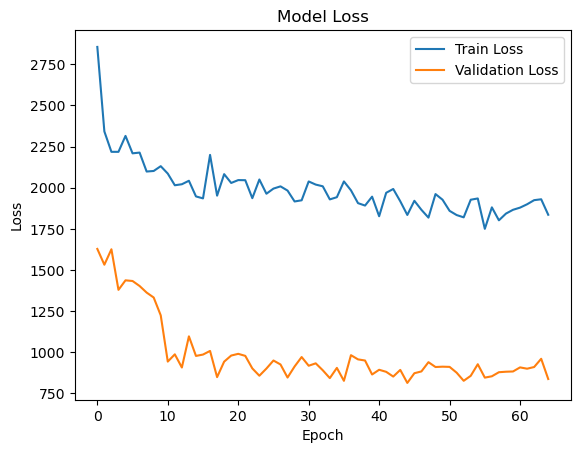

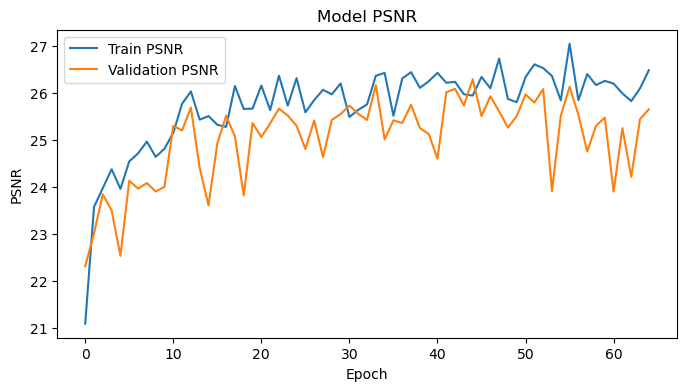

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Bigger the PSNR value is, more prediction and original high res images are same
plt.figure(figsize=(8, 4))
plt.plot(history.history['psnr'], label='Train PSNR')
plt.plot(history.history['val_psnr'], label='Validation PSNR')
plt.title('Model PSNR')
plt.ylabel('PSNR')
plt.xlabel('Epoch')
plt.legend()

plt.show()

#### Test

Testing model with full size bad quality image

2025-05-03 19:46:29.935348: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng13{} for conv %cudnn-conv-bias-activation.219 = (f32[1,256,1020,678]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,100,1020,678]{3,2,1,0} %bitcast.1980, f32[256,100,3,3]{3,2,1,0} %bitcast.1987, f32[256]{0} %bitcast.1989), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/conv2d_42_1/convolution" source_file="/home/tensor/miniconda3/envs/tensor-g/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-05-03 19:46:30.035431: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation too

1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step


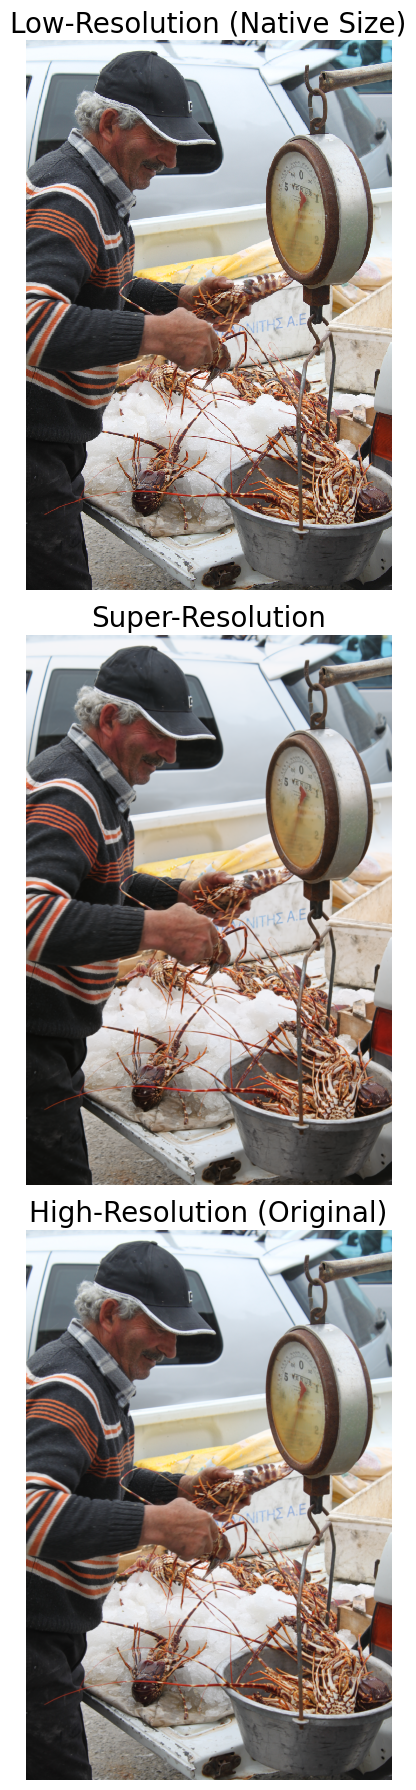

In [18]:
import numpy as np
import matplotlib.pyplot as plt


N = 44  # Index for image to take
for i, hr_img in enumerate(test_ds):
    if i == N:
        hr_img = hr_img.numpy()
        break

# Convert image to bad quality
scale = 2
h, w = hr_img.shape[0], hr_img.shape[1]
lr_img = tf.image.resize(hr_img, [h // scale, w // scale], method="area")
lr_img_blocky = tf.image.resize(lr_img, [h, w], method="nearest").numpy()

# Predict image
lr_input = tf.expand_dims(lr_img, axis=0)
sr_img = model.predict(lr_input)[0]

# Convert for display
hr_img_disp = np.clip(hr_img * 255, 0, 255).astype("uint8")
sr_img_disp = np.clip(sr_img * 255, 0, 255).astype("uint8")
lr_img_disp = np.clip(lr_img_blocky * 255, 0, 255).astype("uint8")

# Show predictions
plt.figure(figsize=(18, 18))

plt.subplot(3, 1, 1)
plt.title("Low-Resolution (Native Size)", fontsize=20)
plt.imshow(np.clip(lr_img.numpy() * 255, 0, 255).astype("uint8"), interpolation='nearest')
plt.axis("off")

plt.subplot(3, 1, 2)
plt.title("Super-Resolution", fontsize=20)
plt.imshow(sr_img_disp)
plt.axis("off")

plt.subplot(3, 1, 3)
plt.title("High-Resolution (Original)", fontsize=20)
plt.imshow(hr_img_disp)
plt.axis("off")

plt.tight_layout()
plt.show()